In [1]:
from make_prediction import DataSplits

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
#sns.set(font="DejaVu Sans")

In [4]:
data = pd.read_pickle("predictions.pkl")

In [5]:
import weighted_ks

In [6]:
import concurrent.futures
import multiprocessing

In [7]:
variables_map = {
    "Brunel_ETA" : "ETA",
    "Brunel_P"   : "P"
}

In [8]:
def distance(sample1, sample2, w1, w2, n_iterations=100):
    assert len(sample1) == len(w1)
    assert len(sample2) == len(w2)
    assert w1.ndim == w2.ndim == 1
    assert sample1.ndim == sample2.ndim == 2
    assert sample1.shape[1] == sample2.shape[1]

    def single_iteration_(dummy):
        del dummy
        direction = np.random.normal(size=(1, sample1.shape[1]))
        return weighted_ks.ks_2samp_w(
                         (sample1 * direction).sum(axis=1),
                         (sample2 * direction).sum(axis=1),
                         w1, w2
                     )
    with concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        result = max(executor.map(single_iteration_, range(n_iterations)))

    return result

In [9]:
import utils_rich_mrartemev as utils_rich

In [10]:
X_cols = utils_rich.raw_feature_columns
Y_cols = utils_rich.dll_columns
w_col  = utils_rich.weight_col
pred_cols = ["predicted_{}".format(col) for col in Y_cols]

In [11]:
from tqdm import tqdm_notebook as tqdm
from itertools import combinations

Calculating random-slice distances between various samples *(not very informative and **quite computationally heavy**)*:

In [12]:
# distances = dict()
# for particle, df in data.items():
#     all_dfs = dict(
#         real_train=(df.train[X_cols + Y_cols], df.train[w_col]),
#         real_val  =(df.val  [X_cols + Y_cols], df.val  [w_col]),
#         real_test =(df.test [X_cols + Y_cols], df.test [w_col]),
#         gen_train=(df.train[X_cols + pred_cols], df.train[w_col]),
#         gen_val  =(df.val  [X_cols + pred_cols], df.val  [w_col]),
#         gen_test =(df.test [X_cols + pred_cols], df.test [w_col])
#     )
#     print(particle)
#     distances[particle] = {
#         (s1, s2) : distance(df1.values, df2.values, w1.values, w2.values)
#         for (s1, (df1, w1)), (s2, (df2, w2)) in tqdm(combinations(all_dfs.items(), 2))
#     }
#     for k, v in distances[particle].items():
#         print(k, v)

# pd.to_pickle(distances, 'distances.pkl')

In [13]:
import time

In [14]:
lhcb_label = r'$\bf LHCb$ preliminary'

def get_percentile_range(array, weights, percentile, min_sumw=100):
    if weights.sum() < min_sumw:
        return array.min(), array.max()
    ix = np.argsort(array)
    array, weights = array[ix], weights[ix]
    cdf = weights.cumsum()
    cdf /= cdf[-1]
    i_left_rev = np.argmax(cdf[::-1] < percentile)
    i_right = np.argmax(cdf > 1. - percentile)
    left = array[::-1][i_left_rev]
    right = array[i_right]
    return left, right

def get_range(weights, *arrays, percentile=0.01):
    lefts, rights = zip(
        *[get_percentile_range(arr, weights, percentile) for arr in arrays]
    )
    return min(lefts), max(rights)

def plot_hist_real_vs_gen(df, col, ax=None, selection=None, n_bins=None, linear=True):
    predicted_col = "predicted_{}".format(col)

    if selection is not None:
        assert len(selection) == 1
        df = df[selection[0]]
    
    real = df[col].values
    gen  = df[predicted_col].values
    w = df[utils_rich.weight_col].values

    if n_bins is None:
        n_bins = max(np.floor(w.sum()**0.5 / 4).astype(int), 4)
    
    bins = np.linspace(
        *get_range(w, real, gen, percentile=0.01 if linear else 0.),
        n_bins + 1
    )
    
    if ax is None:
        fig, ax = plt.subplots()

    _, _, h_real = ax.hist(real, weights=w, bins=bins, label='real')
    _, _, h_gen  = ax.hist(gen , weights=w, bins=bins, label='gen', alpha=0.5)
    if not linear:
        ax.set_yscale('log')
    ax.text(0.05, 1, lhcb_label, {'size': 28}, transform=ax.transAxes, va='bottom', ha='left')
    ax.legend(handles=[h_real[0], h_gen[0]], frameon=False)
    ax.set_xlabel(col)

In [15]:
from itertools import product

def make_bins_selection(df, bins_dict, cols=None):
    if cols is None:
        cols = [col for col in bins_dict.keys()]
    
    features = df[cols].values
    
    bins_nd = [bins_dict[col] for col in cols]
    bins_left  = [[l for l in bins[:-1]] for bins in bins_nd]
    bins_right = [[r for r in bins[1: ]] for bins in bins_nd]

    shape = [len(bins) - 1 for bins in bins_nd]
    shape.append(len(df))
    
    selection = np.array(
        [(features >= lefts).all(axis=1) & (features <= rights).all(axis=1)
         for lefts, rights in zip(product(*bins_left), product(*bins_right))]
    )
    selection_labels = np.array(
        [['{:.3} <= {} <= {:.3}'.format(l, variables_map[name], r)
          for name, l, r in zip(cols, lefts, rights)]
         for lefts, rights in zip(product(*bins_left), product(*bins_right))]
    )
    selection_labels = selection_labels.reshape(*shape[:-1], -1)
    selection = selection.reshape(shape)
    return selection, selection_labels

In [16]:
def get_quantiles(arr, w, n):
    ix = np.argsort(arr)
    arr, w = arr[ix], w[ix]
    cdf = w.cumsum()
    cdf /= cdf[-1]
    thresholds = np.arange(n + 1, dtype=float) / n
    ids = np.argmax(cdf[:,np.newaxis] >= thresholds[np.newaxis,:], axis=0)
    return arr[ids]

In [17]:
from matplotlib import gridspec

def plot_in_bins_2d(function, labels, *selection,
                    figsize=(15, 10),
                    min_samples=50,
                    fontsize=30,
                    params0_dict={},
                    **params):
    assert all(sel.ndim == 3 for sel in selection)
    N0, N1 = selection[0].shape[0], selection[0].shape[1]
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(
                    N0 + 1, N1 + 1,
                    width_ratios =[0.05] + [1] * N1,
                    height_ratios=[0.05] + [1] * N0
                )
    
    for i_row in range(N0):
        for i_col in range(N1):
            ax = plt.subplot(gs[i_row + 1, i_col + 1])
            
            sel = [sel[i_row, i_col] for sel in selection]
            if all(s.sum() > min_samples for s in sel):
                if i_row == 0 and i_col == 0:
                    function(**params, **params0_dict, ax=ax, selection=sel)
                else:
                    function(**params, ax=ax, selection=sel)
            else:
                ax.axis('off')

    for i_row in range(N0):
        ax = plt.subplot(gs[i_row + 1, 0])
        ax.axis('off')
        ax.text(0.0, 0.5, labels[i_row][0][0],
                bbox={'facecolor':'white', 'pad':10},
                transform=ax.transAxes,
                verticalalignment='center',
#                horizontalalignment='center',
                rotation='vertical',
                fontsize=fontsize)

    for i_col in range(N1):
        ax = plt.subplot(gs[0, i_col + 1])
        ax.axis('off')
        ax.text(0.5, -1.0, labels[0][i_col][1],
                bbox={'facecolor':'white', 'pad':10},
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=fontsize)

    fig.tight_layout()
    return fig

In [18]:
plt.rcParams["patch.force_edgecolor"] = False

In [19]:
import os

output_dir = 'pdfs'

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [20]:
data.keys()

dict_keys(['kaon', 'pion', 'proton', 'muon'])

In [ ]:
particles = ['pion', 'kaon', 'proton', 'muon']
variables = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']
bin_cols = ['Brunel_P', 'Brunel_ETA']
nbins = [8, 8]

for particle in particles:
    print("Working on:", particle)
    df = data[particle].test

    bins_dict = {col : get_quantiles(df[col].values,
                                     df[utils_rich.weight_col].values,
                                     n)
                 for col, n in zip(bin_cols, nbins)}

    selection, labels = make_bins_selection(df, bins_dict, bin_cols)
    
    for variable in tqdm(variables):
        fig = plot_in_bins_2d(plot_hist_real_vs_gen,
                              labels[::-1],
                              selection[::-1],
                              figsize=(10 * nbins[1], 10 * nbins[0]), df=df, col=variable)
        file_name = "{particle}_{target}_in_{y}_vs_{x}.pdf".format(
            particle=particle, target=variable,
            y=bin_cols[0], x=bin_cols[1]
        )
        fig.savefig(os.path.join(output_dir, file_name))

In [22]:
def plot_hist_real_vs_gen_2types(df1, df2, label1, label2, col,
                                 ax=None, selection=None, n_bins=None,
                                 linear=True, legend=False):
    predicted_col = "predicted_{}".format(col)

    if selection is not None:
        assert len(selection) == 2
        df1 = df1[selection[0]]
        df2 = df2[selection[1]]
    
    real1 = df1[col].values
    gen1  = df1[predicted_col].values
    w1 = df1[utils_rich.weight_col].values

    real2 = df2[col].values
    gen2  = df2[predicted_col].values
    w2 = df2[utils_rich.weight_col].values
    
    if n_bins is None:
        n_bins1 = max(np.floor(w1.sum()**0.5 / 4).astype(int), 4)
        n_bins2 = max(np.floor(w2.sum()**0.5 / 4).astype(int), 4)
        n_bins = min(n_bins1, n_bins2)
    
    left_1, right_1 = get_range(w1, real1, gen1, percentile=0.01 if linear else 0.)
    left_2, right_2 = get_range(w2, real2, gen2, percentile=0.01 if linear else 0.)
    bins = np.linspace(
        min(left_1, left_2),
        max(right_1, right_2),
        n_bins + 1
    )

    if ax is None:
        fig, ax = plt.subplots()

    _, _, h_real1 = ax.hist(real1, weights=w1, bins=bins, label='{} (real)'.format(label1), alpha=0.35, color='r', density=True)
    _, _, h_gen1  = ax.hist(gen1 , weights=w1, bins=bins, label='{} (gen)' .format(label1), histtype='step', linewidth=3., color='r', density=True)
    _, _, h_real2 = ax.hist(real2, weights=w2, bins=bins, label='{} (real)'.format(label2), alpha=0.35, color='b', density=True)
    _, _, h_gen2  = ax.hist(gen2 , weights=w2, bins=bins, label='{} (gen)' .format(label2), histtype='step', linewidth=3., color='b', density=True)
    
    if linear:
        ax.set_ylim(bottom=0)
    else:
        ax.set_yscale('log')
        
    ax.text(0.05, 1, lhcb_label, {'size': 28}, transform=ax.transAxes, va='bottom', ha='left')
    if legend:
        ax.legend(handles=[h_real1[0], h_gen1[0], h_real2[0], h_gen2[0]], frameon=False)
    ax.set_xlabel(col, ha='right', x=1)
    ax.minorticks_on()

In [23]:
def make_n_sample_bins(samples, weights, n):
    edges = np.array([get_percentile_range(s, w, percentile=0.001)
                      for s, w in zip(samples, weights)])
    l, r = edges[:,0].max(), edges[:,1].min()
    selection = (samples[0] >= l) & (samples[0] <= r)
    return get_quantiles(samples[0][selection], weights[0][selection], n)

In [24]:
def make_vs_plot(particle1, particle2, variable, nbins, bin_cols=['Brunel_P', 'Brunel_ETA'], subslice=None, save=True):
    df1 = data[particle1].test
    df2 = data[particle2].test

    bins_dict = {col : make_n_sample_bins(
                                     [df1[col]                  .values, df2[col]                  .values],
                                     [df1[utils_rich.weight_col].values, df2[utils_rich.weight_col].values],
                                     n)
                 for col, n in zip(bin_cols, nbins)}

    selection1, labels1 = make_bins_selection(df1, bins_dict, bin_cols)
    selection2, labels2 = make_bins_selection(df2, bins_dict, bin_cols)

    assert((labels1 == labels2).all())

    if subslice is not None:
        selection1 = selection1[subslice[0], subslice[1]]
        selection2 = selection2[subslice[0], subslice[1]]
        labels1    = labels1   [subslice[0], subslice[1]]
        labels2    = labels2   [subslice[0], subslice[1]]
        
        fix_none = lambda *args: [str(x) if x is not None else "N" for x in args]
        subslice_string = "S0_{}_{}_{}_S1_{}_{}_{}".format(
                                    *fix_none(subslice[0].start,
                                              subslice[0].stop,
                                              subslice[0].step),
                                    *fix_none(subslice[1].start,
                                              subslice[1].stop,
                                              subslice[1].step),
                                )

    figsize = (10 * selection1.shape[1],
               10 * selection1.shape[0])

    fig = plot_in_bins_2d(plot_hist_real_vs_gen_2types,
                          labels1[::-1],
                          selection1[::-1], selection2[::-1],
                          params0_dict=dict(legend=True),
                          figsize=figsize, df1=df1, df2=df2,
                          label1=particle1, label2=particle2, col=variable)
    if save:
        file_name = "{particle1}_vs_{particle2}_{target}_in_{y}_vs_{x}_{n0}x{n1}_{subs}.pdf".format(
            particle1=particle1, particle2=particle2, target=variable,
            y=bin_cols[0], x=bin_cols[1], n0=nbins[0], n1=nbins[1],
            subs="full" if subslice is None else subslice_string
        )
        fig.savefig(os.path.join(output_dir, file_name))

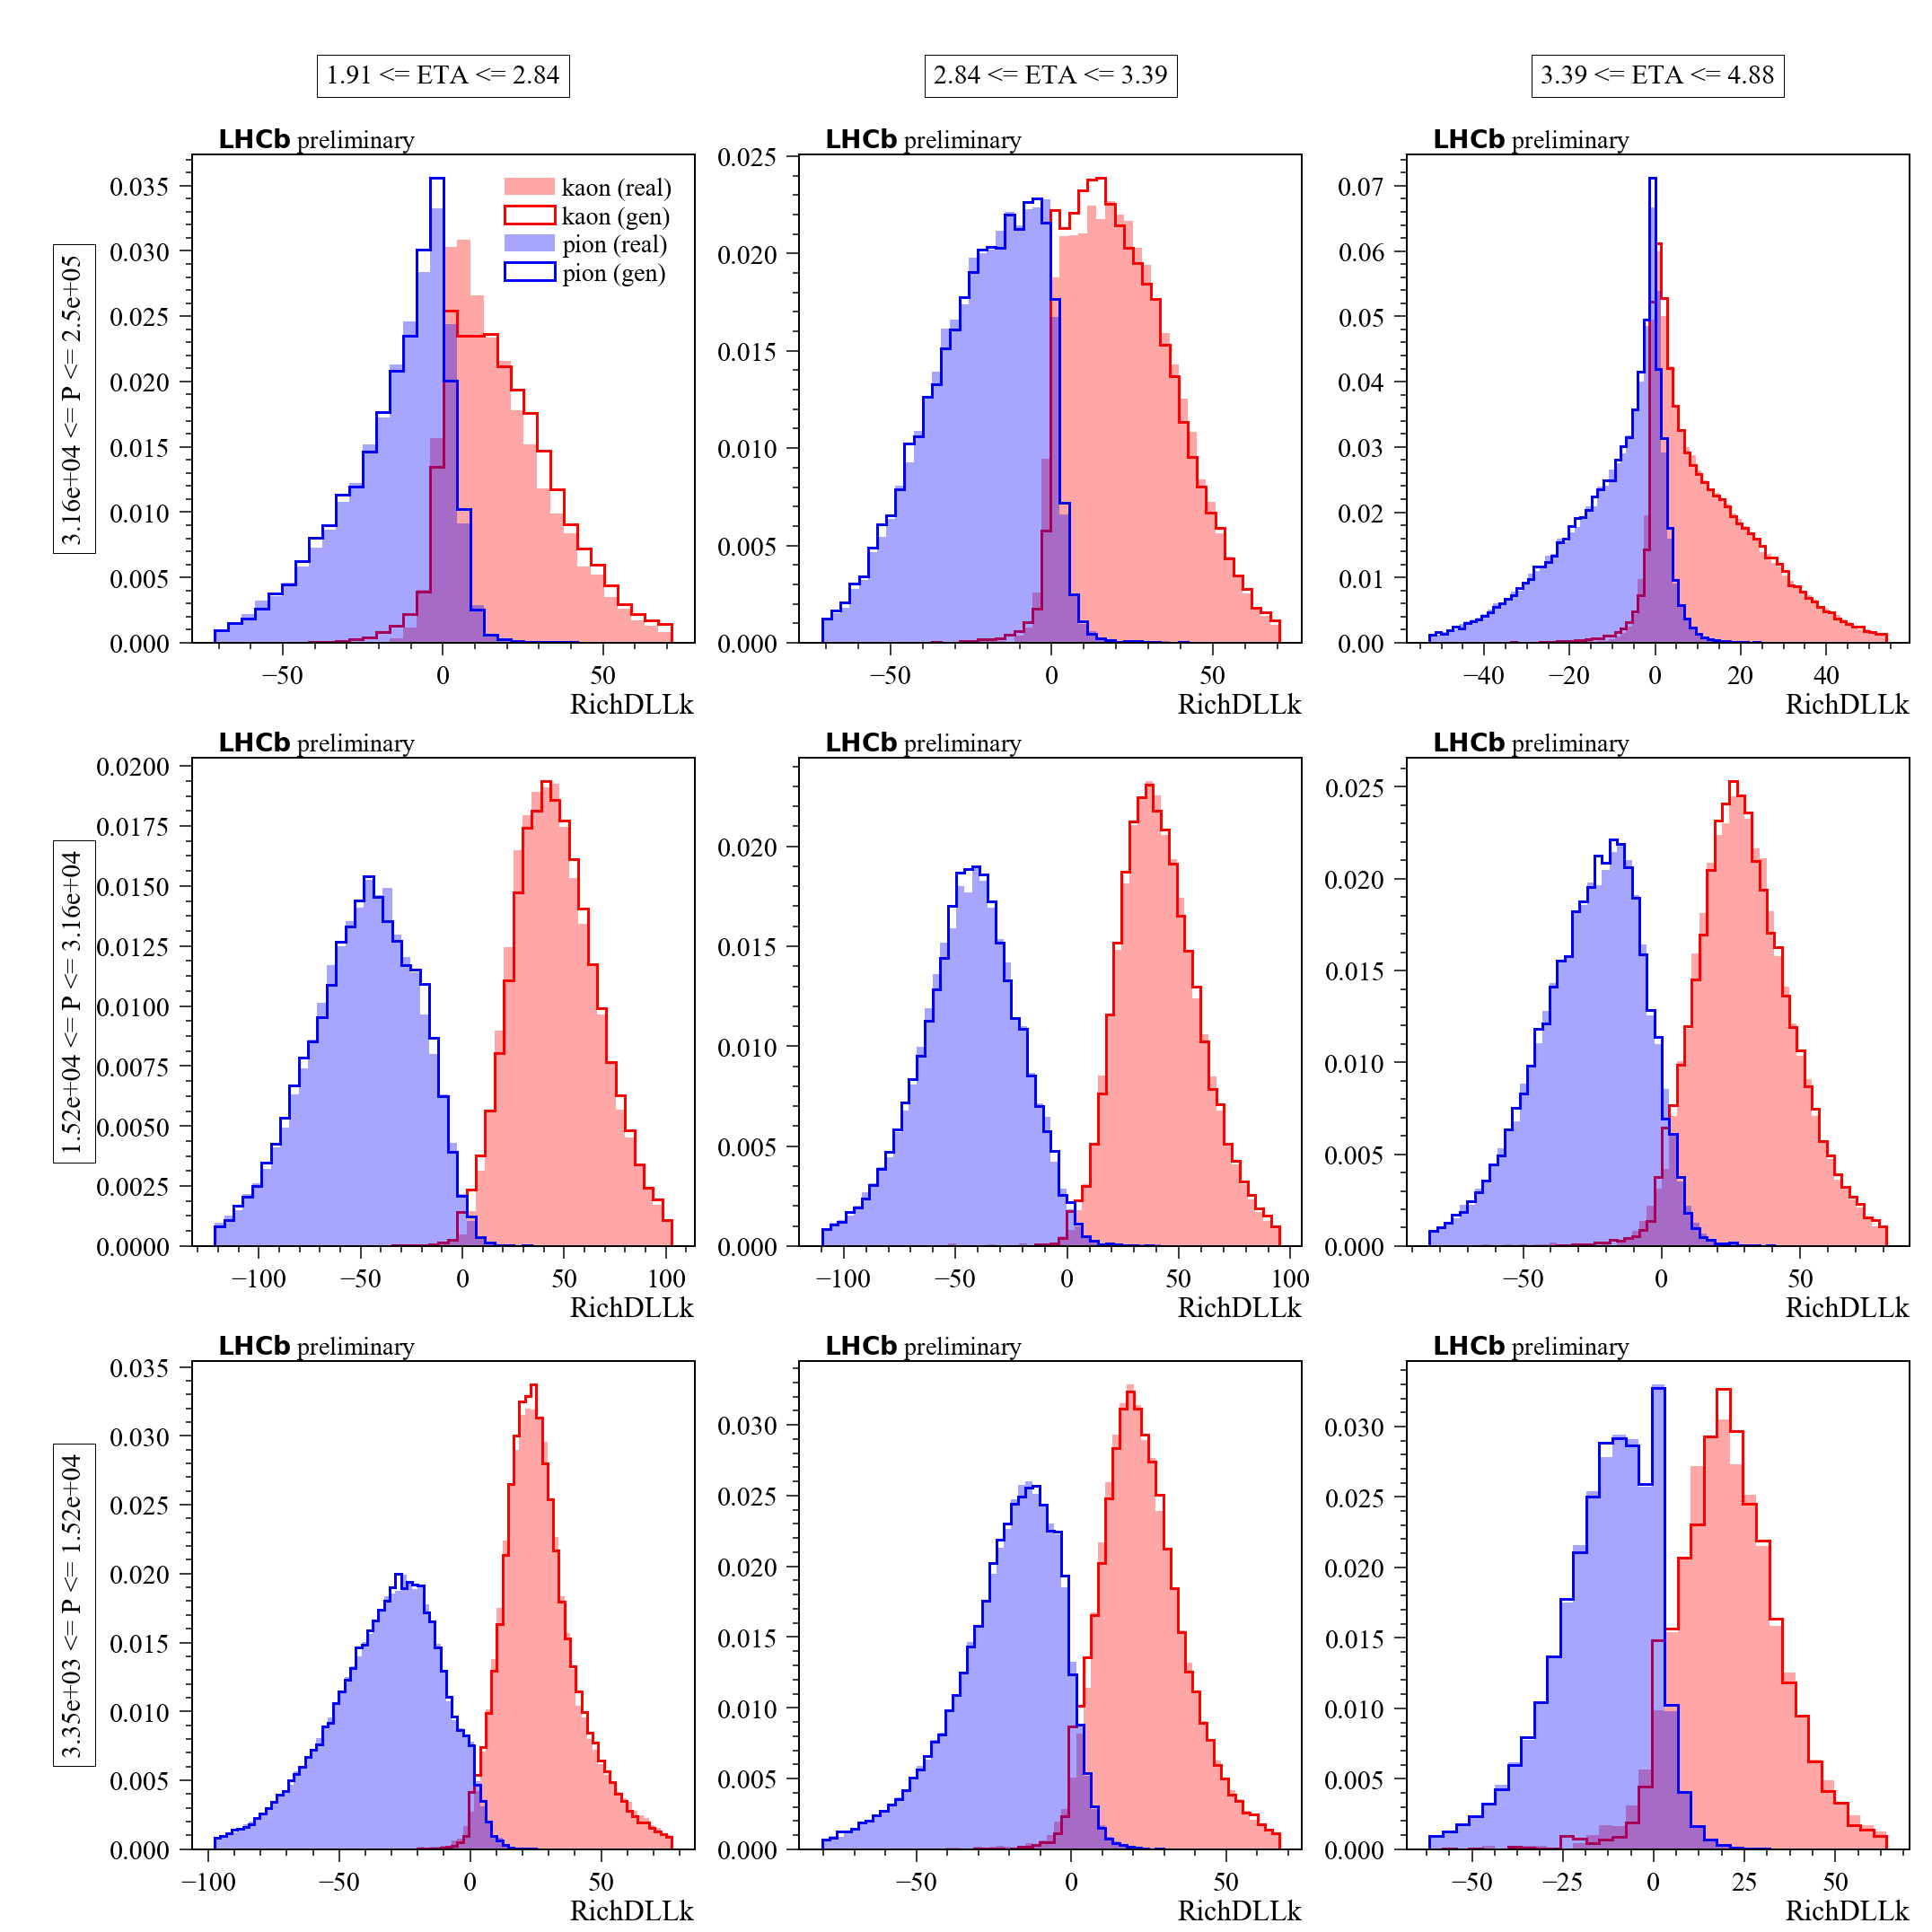

In [25]:
make_vs_plot(
    particle1='kaon',
    particle2='pion',
    variable='RichDLLk',
    nbins=[3, 3],
)

In [ ]:
make_vs_plot(
    particle1 = 'kaon',
    particle2 = 'pion',
    variable = 'RichDLLk',
    nbins = [8, 8],
)

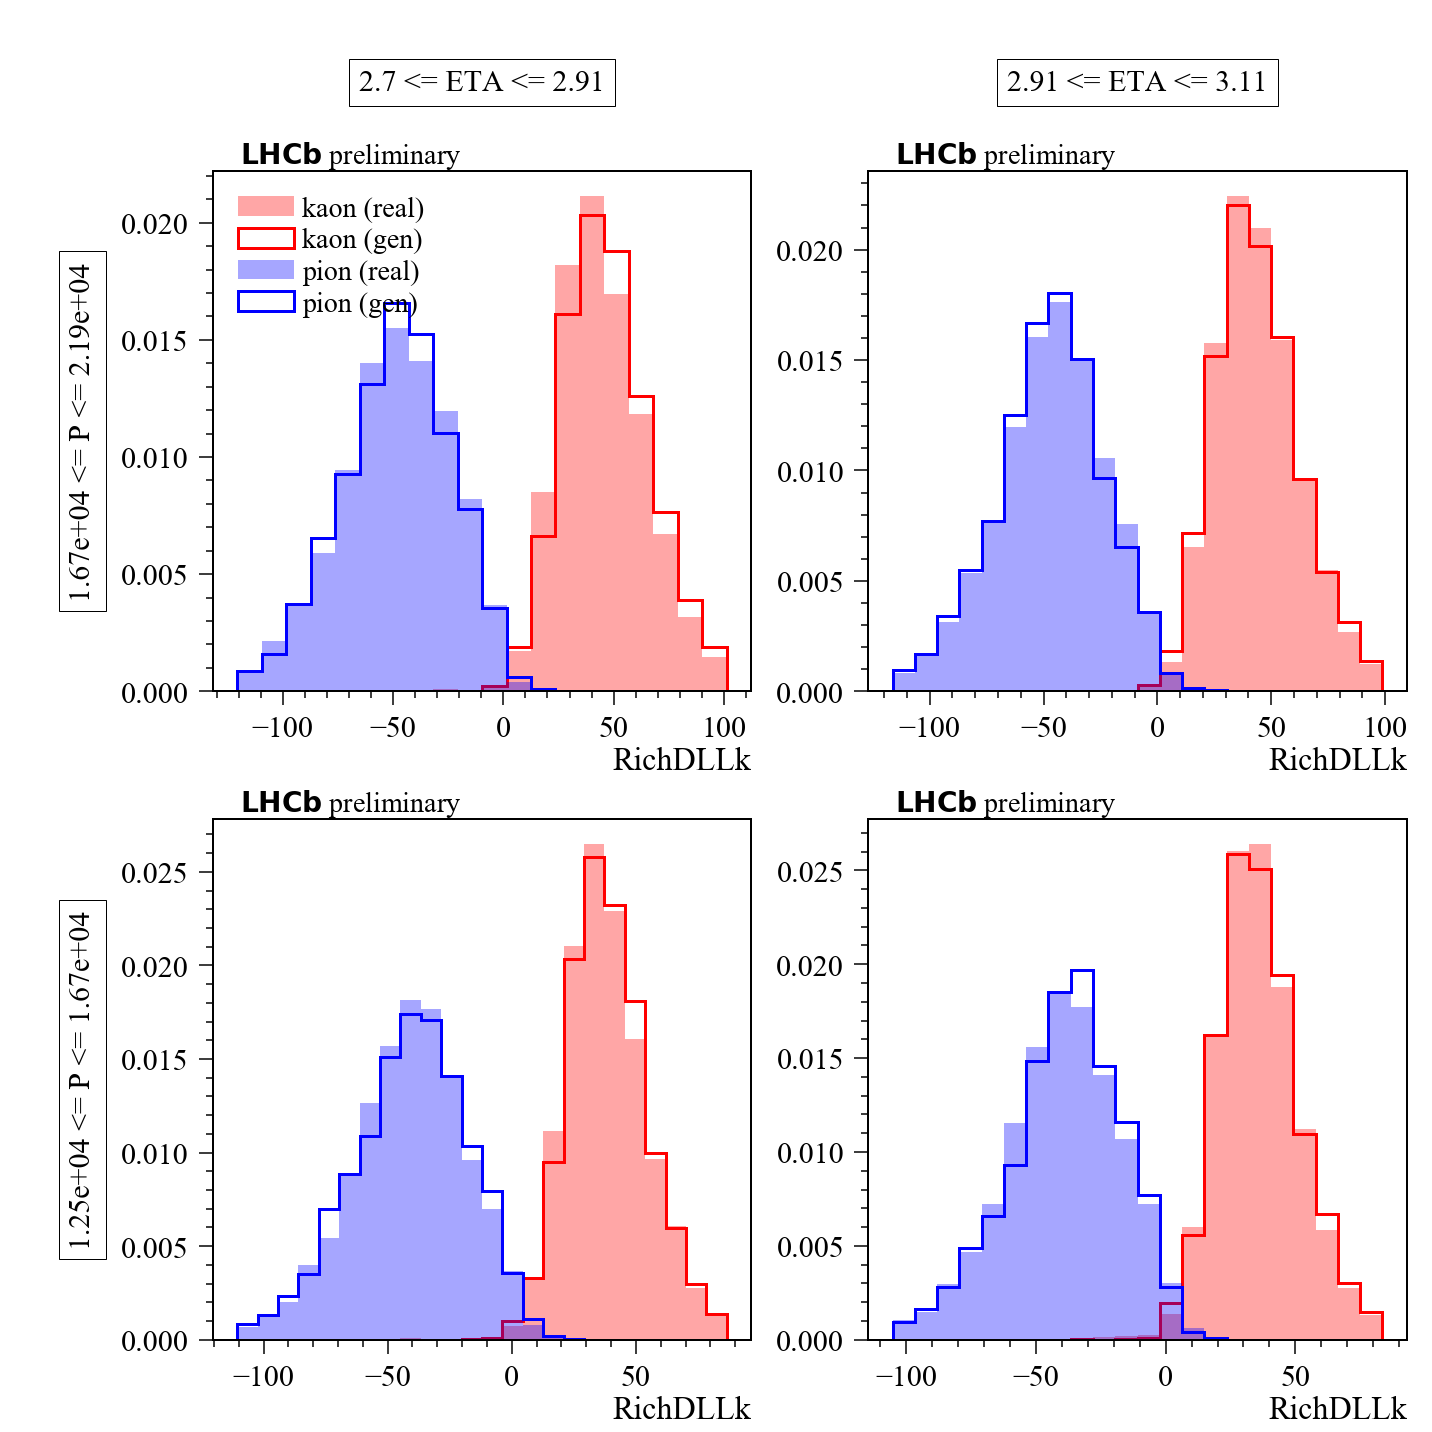

In [27]:
make_vs_plot(
    particle1 = 'kaon',
    particle2 = 'pion',
    variable = 'RichDLLk',
    nbins = [8, 8],
    subslice = [slice(2, 4), slice(2, 4)]
)

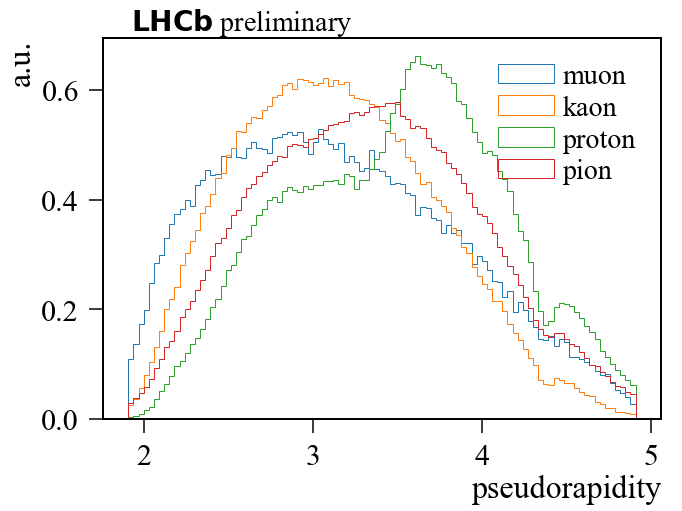

In [28]:
l1, r1 = get_percentile_range(data['muon'  ].test.Brunel_ETA.values, data['muon'  ].test.probe_sWeight.values, percentile=0.01)
l2, r2 = get_percentile_range(data['kaon'  ].test.Brunel_ETA.values, data['kaon'  ].test.probe_sWeight.values, percentile=0.01)
l3, r3 = get_percentile_range(data['proton'].test.Brunel_ETA.values, data['proton'].test.probe_sWeight.values, percentile=0.01)
l4, r4 = get_percentile_range(data['pion'  ].test.Brunel_ETA.values, data['pion'  ].test.probe_sWeight.values, percentile=0.01)

plt.figure(figsize=(10, 7))

bins = np.linspace(min(l1, l2, l3, l4), max(r1, r2, r3, r4), 100)
_, _, h_muon   = plt.hist(data['muon'  ].test.Brunel_ETA, weights=data['muon'  ].test.probe_sWeight, label='muon'  , bins=bins, density=True, histtype='step')
_, _, h_kaon   = plt.hist(data['kaon'  ].test.Brunel_ETA, weights=data['kaon'  ].test.probe_sWeight, label='kaon'  , bins=bins, density=True, histtype='step')
_, _, h_proton = plt.hist(data['proton'].test.Brunel_ETA, weights=data['proton'].test.probe_sWeight, label='proton', bins=bins, density=True, histtype='step')
_, _, h_pion   = plt.hist(data['pion'  ].test.Brunel_ETA, weights=data['pion'  ].test.probe_sWeight, label='pion'  , bins=bins, density=True, histtype='step')

plt.text(0.05, 1, lhcb_label, {'size': 28}, transform=plt.gca().transAxes, va='bottom', ha='left')

plt.legend(handles=[h_muon[0], h_kaon[0], h_proton[0], h_pion[0]], frameon=False)
plt.xlabel('pseudorapidity', ha='right', x=1)
plt.ylabel('a.u.', ha='right', y=1)

file_name = "ETA.pdf"
plt.savefig(os.path.join(output_dir, file_name))

bins_eta = bins

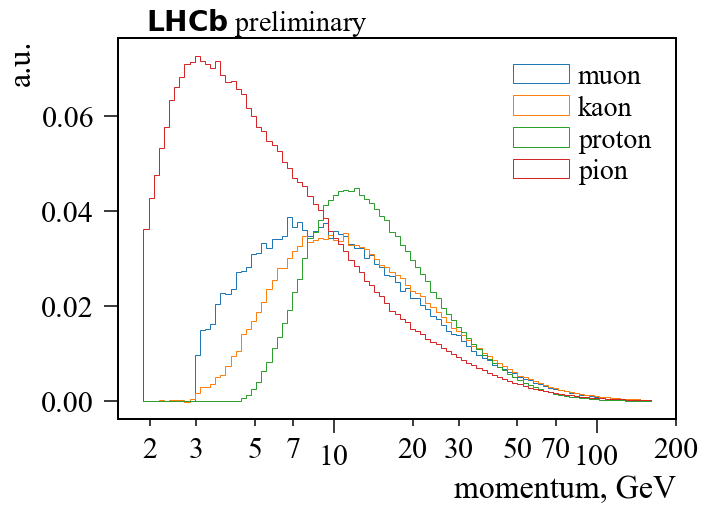

In [29]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, LogLocator


l1, r1 = get_percentile_range(data['muon'  ].test.Brunel_P.values / 1000, data['muon'  ].test.probe_sWeight.values, percentile=0.01)
l2, r2 = get_percentile_range(data['kaon'  ].test.Brunel_P.values / 1000, data['kaon'  ].test.probe_sWeight.values, percentile=0.01)
l3, r3 = get_percentile_range(data['proton'].test.Brunel_P.values / 1000, data['proton'].test.probe_sWeight.values, percentile=0.01)
l4, r4 = get_percentile_range(data['pion'  ].test.Brunel_P.values / 1000, data['pion'  ].test.probe_sWeight.values, percentile=0.01)
l = min(l1, l2, l3, l4)
r = max(r1, r2, r3, r4)
bins = np.logspace(np.log10(l), np.log10(r), 100)

plt.figure(figsize=(10, 7))

_, _, h_muon   = plt.hist(data['muon'  ].test.Brunel_P / 1000, weights=data['muon'  ].test.probe_sWeight, label='muon'  , bins=bins, density=True, histtype='step')
_, _, h_kaon   = plt.hist(data['kaon'  ].test.Brunel_P / 1000, weights=data['kaon'  ].test.probe_sWeight, label='kaon'  , bins=bins, density=True, histtype='step')
_, _, h_proton = plt.hist(data['proton'].test.Brunel_P / 1000, weights=data['proton'].test.probe_sWeight, label='proton', bins=bins, density=True, histtype='step')
_, _, h_pion   = plt.hist(data['pion'  ].test.Brunel_P / 1000, weights=data['pion'  ].test.probe_sWeight, label='pion'  , bins=bins, density=True, histtype='step')

plt.text(0.05, 1, lhcb_label, {'size': 28}, transform=plt.gca().transAxes, va='bottom', ha='left')

plt.legend(handles=[h_muon[0], h_kaon[0], h_proton[0], h_pion[0]], frameon=False)
plt.xscale('log')
plt.xlabel('momentum, GeV', ha='right', x=1)
plt.ylabel('a.u.', ha='right', y=1)
plt.gca().get_xaxis().set_minor_formatter(ScalarFormatter())
plt.gca().get_xaxis().set_minor_locator(LogLocator(subs=[2,3,5,7]))
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())

file_name = "P.pdf"
plt.savefig(os.path.join(output_dir, file_name))

bins_P = bins

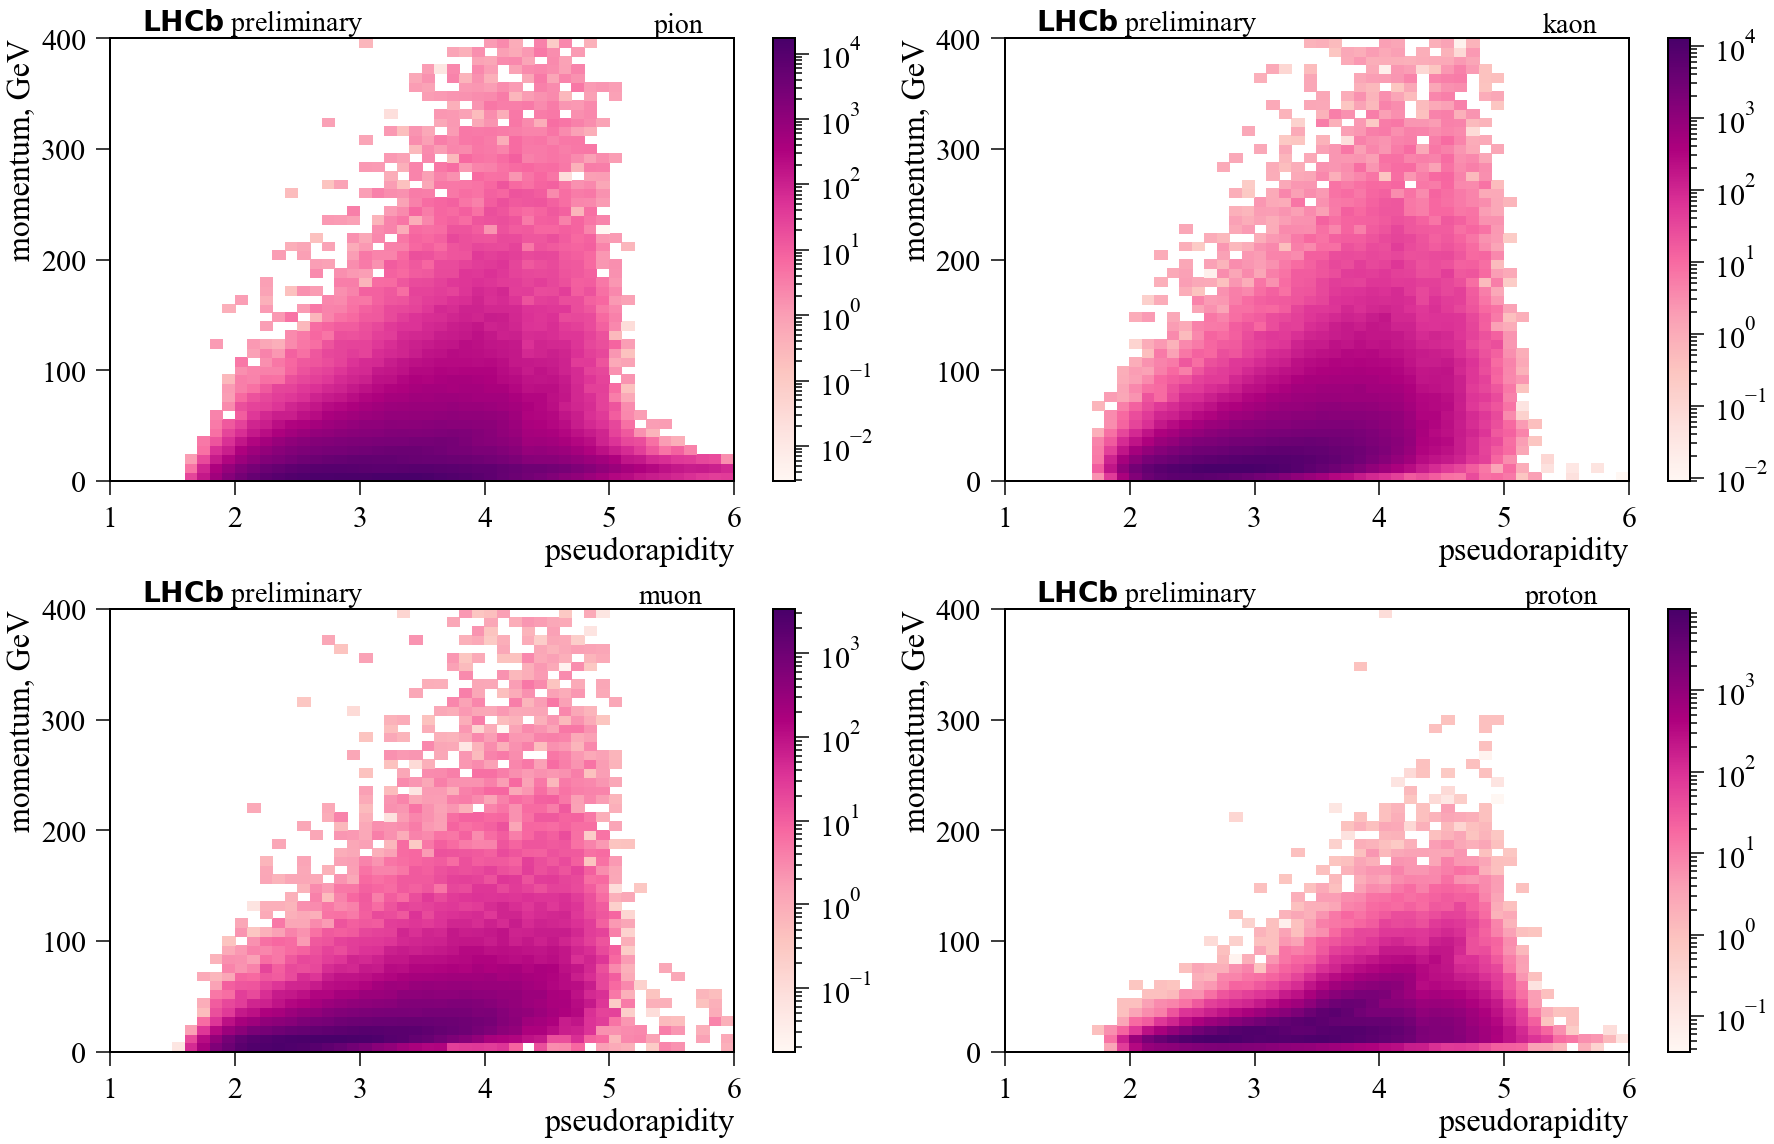

In [30]:
fig = plt.figure(figsize=(25, 16))

for i, particle in enumerate(['pion', 'kaon', 'muon', 'proton'], 1):
    var_P   = data[particle].test.Brunel_P / 1000
    var_ETA = data[particle].test.Brunel_ETA
    var_w   = data[particle].test.probe_sWeight
    plt.subplot(2, 2, i)
    plt.hist2d(var_ETA, var_P, weights=var_w, bins=(np.linspace(1,   6, 51),
                                                    np.linspace(0, 400, 51)),
               cmap='RdPu', norm=mpl.colors.LogNorm())
    plt.xlabel('pseudorapidity', ha='right', x=1)
    plt.ylabel('momentum, GeV' , ha='right', y=1)

    plt.text(0.95, 1, particle  , {'size': 28}, transform=plt.gca().transAxes, va='bottom', ha='right');
    plt.text(0.05, 1, lhcb_label, {'size': 28}, transform=plt.gca().transAxes, va='bottom', ha='left');

    plt.colorbar()

fig.tight_layout();

fig.savefig(os.path.join(output_dir, "P_vs_ETA.pdf"))

In [31]:
from my_roc_auc import my_roc_auc as my_roc_auc_imp

def my_roc_auc(labels, predictions, weights):
    result = my_roc_auc_imp(labels, predictions, weights)
    assert 0 <= result <= 1.10
#     if not 0 <= result <= 1.05:
#         print("--------")
#         print('res:', result)
#         print('labels:', np.unique(labels))
#         print('sumw:', weights.sum())
#         print('sumw0:', weights[labels==0].sum())
#         print('sumw1:', weights[labels==1].sum())
    return result

def my_delta_roc_auc_bootstrap(classes, predictions_1, predictions_2, weights, n_bootstrap=100):
    result = np.empty(shape=n_bootstrap, dtype=float)
    for i in range(n_bootstrap):
        ids = np.random.randint(0, len(classes), len(classes))
        auc_1 = my_roc_auc(classes[ids], predictions_1[ids], weights[ids])
        auc_2 = my_roc_auc(classes[ids], predictions_2[ids], weights[ids])
        result[i] = auc_1 - auc_2
    return result

In [32]:
def get_aucs_in_bins(particles, signal_particle, variable, bin_cols, nbins, n_bootstrap=100):
    predicted_variable = 'predicted_{}'.format(variable)
    bins_dict = {col : make_n_sample_bins([data[p].test[col].values for p in particles],
                                          [data[p].test[utils_rich.weight_col].values for p in particles], n)
                 for col, n in zip(bin_cols, nbins)}
    cols = bin_cols + [variable, predicted_variable, utils_rich.weight_col]
    
    signal_sample = data[signal_particle].test[cols].copy()
    signal_sample['signal'] = 1
    bg_sample = pd.concat([data[p].test[cols] for p in particles if p != signal_particle], axis=0).copy()
    bg_sample['signal'] = 0
    
    sample = pd.concat([signal_sample, bg_sample], axis=0).reset_index(drop=True)
    selection, labels = make_bins_selection(sample, bins_dict, bin_cols)
    
    assert selection.ndim == 3
    
    aucs_real = np.empty(shape=selection.shape[:-1], dtype=float)
    aucs_gen  = np.empty(shape=selection.shape[:-1], dtype=float)
    delta_auc_error = np.empty(shape=selection.shape[:-1], dtype=float)
    for i_row in tqdm(range(selection.shape[0])):
        for i_col in range(selection.shape[1]):
            current_sample = sample[selection[i_row, i_col]]
            aucs_real[i_row, i_col] = my_roc_auc(current_sample['signal'].values,
                                                 current_sample[variable].values,
                                                 current_sample[utils_rich.weight_col].values)
            aucs_gen [i_row, i_col] = my_roc_auc(current_sample['signal'].values,
                                                 current_sample[predicted_variable].values,
                                                 current_sample[utils_rich.weight_col].values)
            
            delta_auc_error[i_row, i_col] = my_delta_roc_auc_bootstrap(
                current_sample['signal'].values,
                current_sample[predicted_variable].values,
                current_sample[variable].values,
                current_sample[utils_rich.weight_col].values,
                n_bootstrap=n_bootstrap
            ).std()
    
    return aucs_real, aucs_gen, delta_auc_error, bins_dict

In [33]:
def plot_delta_auc_heatmap(
            particles,
            signal_particle,
            variable,
            bin_cols,
            nbins, title, n_bootstrap=20,
            relative=True,
            vmin=None,
            vmax=None
        ):
    if not relative:
        n_bootstrap = 1

    aucs_real, aucs_gen, delta_auc_error, bins_dict = get_aucs_in_bins(
        particles, signal_particle, variable, bin_cols, nbins, n_bootstrap=n_bootstrap
    )
    diff = aucs_gen - aucs_real

    if relative:
        diff = abs(diff) / delta_auc_error

    l, r = diff.min(), diff.max()
    ticks = [0.0001, 0.001, 0.01, 0.1]
    sns.heatmap(diff, cmap='RdPu' if relative else 'seismic', vmin=vmin, vmax=vmax,
                annot=True, fmt=".2f" if relative else ".3f", annot_kws={"size": 24});
    bins = [bins_dict[col] / 1000 if col == 'Brunel_P' else bins_dict[col]
            for col in bin_cols]
    labels = ['momentum, GeV' if col == 'Brunel_P' else
              'pseudorapidity' if col == 'Brunel_ETA' else col
              for col in bin_cols]
    plt.yticks(range(len(bins_dict[bin_cols[0]]) + 1), np.round(bins[0], 1));
    plt.xticks(range(len(bins_dict[bin_cols[1]]) + 1), np.round(bins[1], 1));
    plt.ylabel(labels[0], ha='right', y=1)
    plt.xlabel(labels[1], ha='right', x=1)
    plt.text(0.99, 1, title, {'size': 22}, transform=plt.gca().transAxes, va='bottom', ha='right');
    plt.ylim(0, len(bins_dict[bin_cols[0]]) - 1);
    plt.xlim(0, len(bins_dict[bin_cols[1]]) - 1);

In [34]:
def plot_delta_auc(signal_particle, variable,
                   bin_cols=['Brunel_P', 'Brunel_ETA'],
                   particles=['pion'],
                   nbins=[6, 6],
                   n_bootstrap=200,
                   figsize=(12, 10),
                   relative=True,
                   vmin=None,
                   vmax=None):
    if signal_particle not in particles:
        particles = [signal_particle] + particles
    
    bg_particles = [p for p in particles if not p == signal_particle]
    bg_string = " + ".join(["{}s".format(p) for p in bg_particles])
    if len(bg_particles) > 1:
        bg_string = '[{}]'.format(bg_string)
    
    plt.figure(figsize=figsize)
    
    if relative:
        title_base = r"$|\Delta AUC| / \sigma(\Delta AUC)$"
    else:
        title_base = r"$\Delta AUC$"

    title = "{}, using {}, {}s VS {}".format(title_base, variable,
                                             signal_particle, bg_string)

    plot_delta_auc_heatmap(particles, signal_particle, variable, bin_cols, nbins, 
                           title=title, n_bootstrap=n_bootstrap, relative=relative, vmin=vmin, vmax=vmax)
    plt.text(0.99, 1.05, lhcb_label, {'size': 25}, transform=plt.gca().transAxes, va='bottom', ha='right');

    file_name = "{base}_{variable}_{signal_particle}_vs_all.pdf".format(
        base="DeltaAUCOverError" if relative else "DeltaAUC",
        variable=variable, signal_particle=signal_particle, 
    )
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))

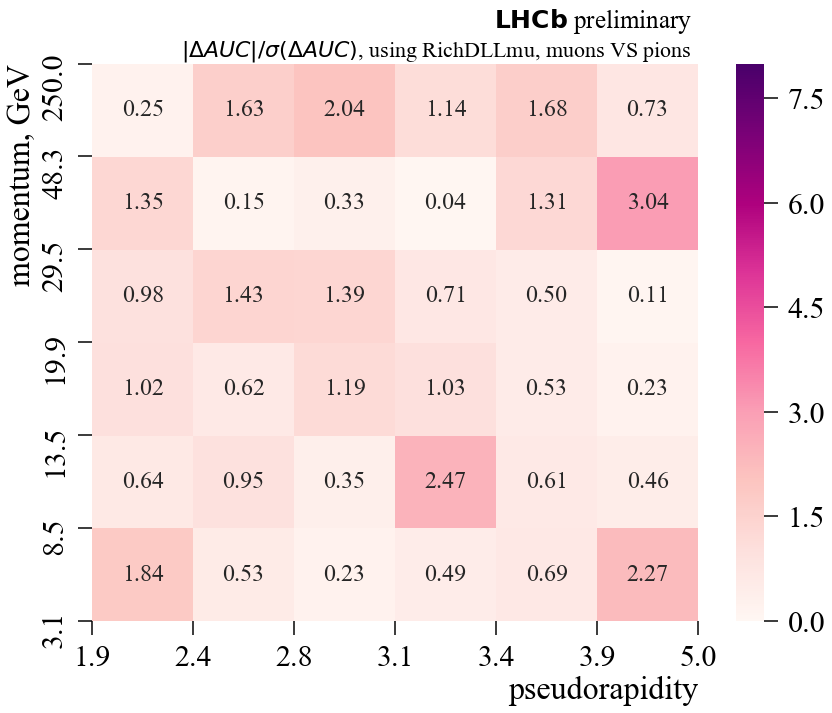

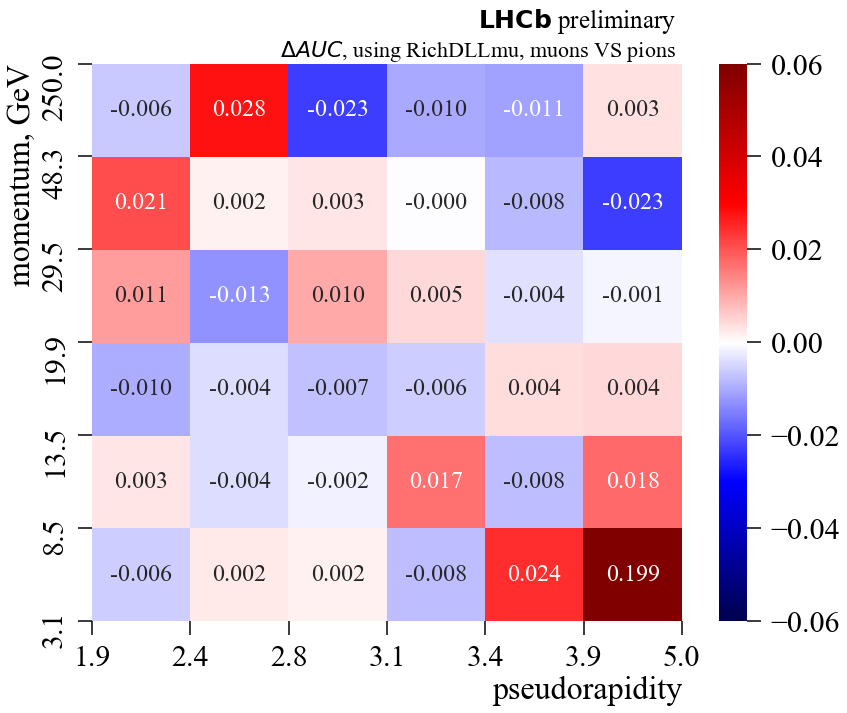

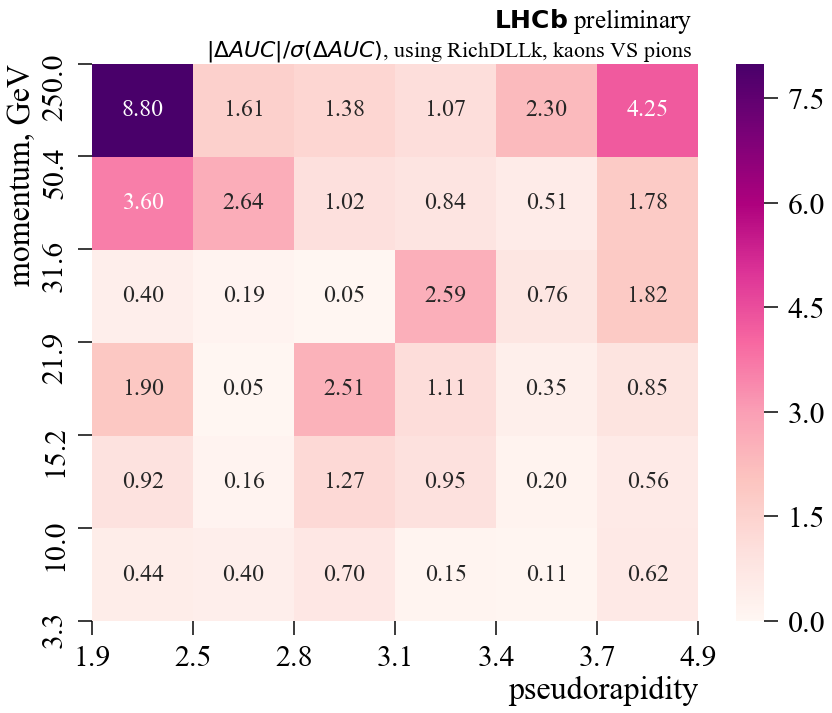

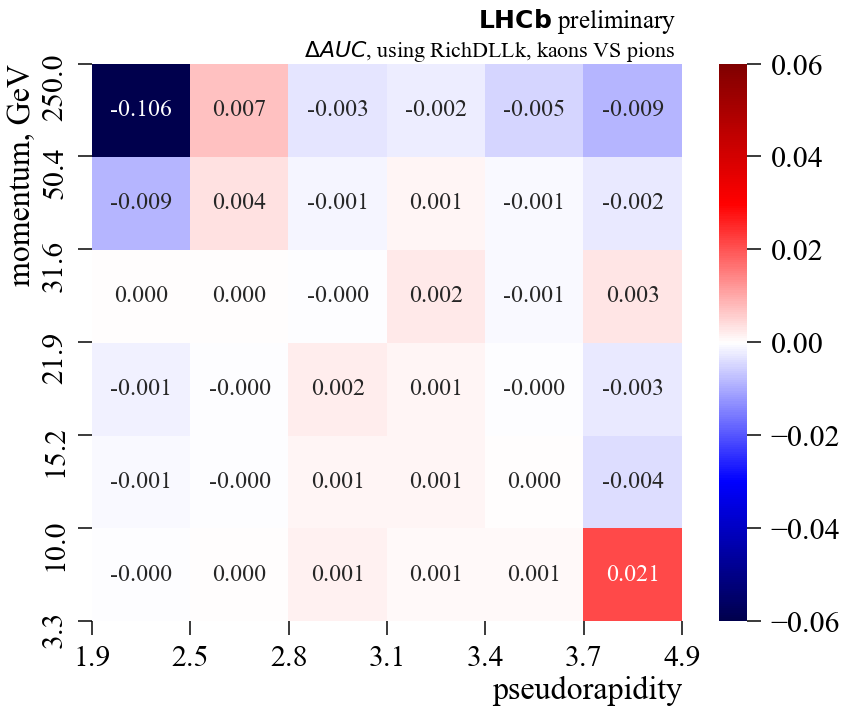

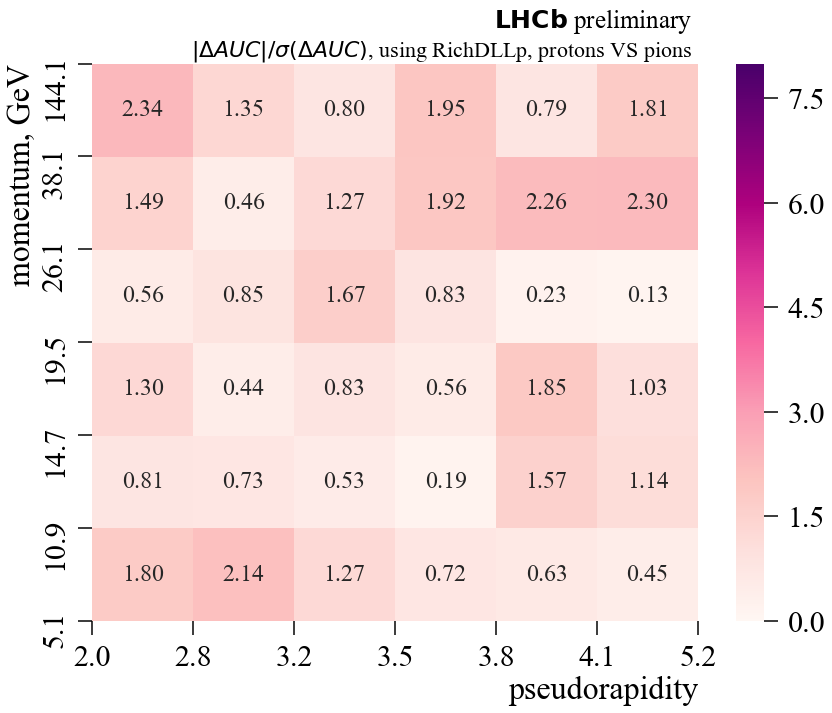

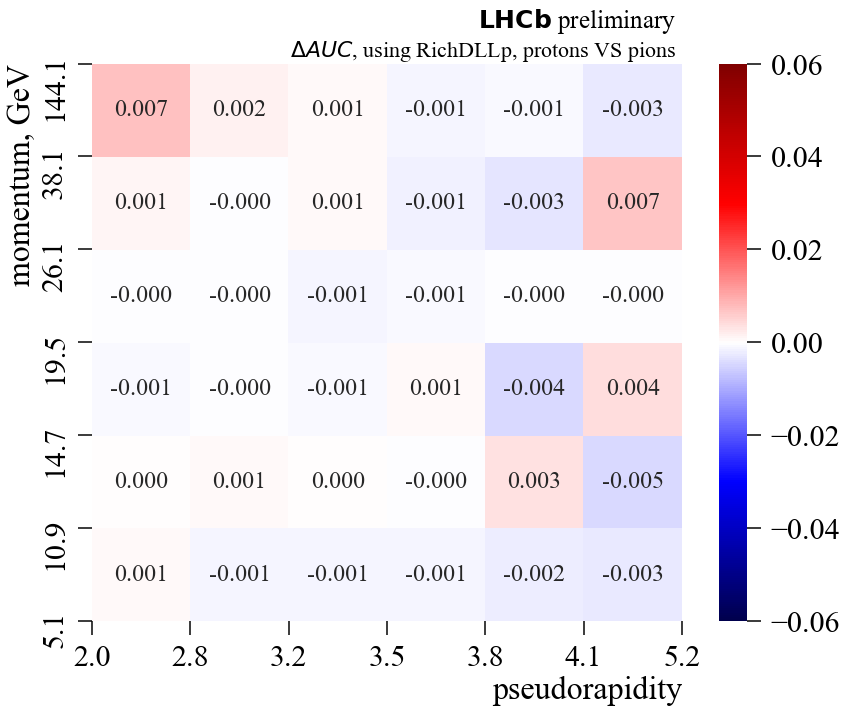

In [35]:
vmin_rel = 0
vmax_rel = 8
vmin_abs = -0.06
vmax_abs =  0.06

plot_delta_auc(signal_particle='muon',
               variable='RichDLLmu', n_bootstrap=200, vmin=vmin_rel, vmax=vmax_rel)

plot_delta_auc(signal_particle='muon',
               variable='RichDLLmu', relative=False, vmin=vmin_abs,  vmax=vmax_abs)

plot_delta_auc(signal_particle='kaon',
               variable='RichDLLk', n_bootstrap=200, vmin=vmin_rel, vmax=vmax_rel)

plot_delta_auc(signal_particle='kaon',
               variable='RichDLLk', relative=False, vmin=vmin_abs,  vmax=vmax_abs)

plot_delta_auc(signal_particle='proton',
               variable='RichDLLp', n_bootstrap=200, vmin=vmin_rel, vmax=vmax_rel)

plot_delta_auc(signal_particle='proton',
               variable='RichDLLp', relative=False, vmin=vmin_abs,  vmax=vmax_abs)